In [1]:
import os
import glob
import csv
import pprint as pp
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from functools import reduce

import omop_analyze
import s4s_analyze

original_path = os.getcwd()

In [2]:
def omop_formatted(tables):
    return {filename: len(table) for filename, table in tables.items()}
    
def s4s_formatted(counts):
    return {k: len(v) for k, v in counts.items()}

def filter_matches(omop_tables, s4s_uniques):
    return filter_procedures(omop_tables, s4s_uniques)

def filter_procedures(omop_tables, s4s_uniques):
    return omop_tables, s4s_uniques

def csv_to_dicts(filename):
    with open(filename, encoding="utf8") as csv_file:
        items = (filename, list(csv.DictReader(csv_file, delimiter="\t")))
    return items

def fetch_at_path(resource, path):
    if type(path) == type(''):
        path = path.split('.')
    def walk(data, k):
        if isinstance(data, dict):
            return data.get(k)
        elif isinstance(data, list):
            return [reduce(walk, [k], el) for el in data]
        return None
    return reduce(walk, path, resource)

def path_for_resource(resource):
    resource_type = resource['resourceType']
    code_paths = {
        'OperationOutcome': ['details', 'coding'],
        'MedicationOrder': ['medicationCodeableConcept', 'coding'], # no idea what I actually need here
        'MedicationStatement': ['medicationCodeableConcept', 'coding'],
        'AllergyIntolerance': ['substance', 'coding'],
        'Observation': ['category', 'coding'], #code, coding
        'Immunization': ['vaccineCode', 'coding'],
        'Condition': ['category', 'coding'], #code, coding
        'DocumentReference': ['code', 'coding'],
        'Procedure': ['code', 'coding'],
        
    }
    return code_paths[resource_type]

In [3]:
vocab = csv_to_dicts('VOCABULARY.csv')[1]
vocab_df = pd.DataFrame(vocab)
concept = csv_to_dicts('CONCEPT.csv')[1]
concept_df = pd.DataFrame(concept)
concept_cpt4 = csv_to_dicts('CONCEPT_CPT4.csv')[1]
cpt4_df = pd.DataFrame(concept_cpt4)
concept_aouppi = csv_to_dicts('CONCEPT_AOUPPI.csv')[1]
aouppi_df = pd.DataFrame(concept_aouppi)

In [4]:
concept_df.set_index(['concept_id',], inplace=True)
cpt4_df.set_index(['concept_id',], inplace=True)
aouppi_df.set_index(['concept_id',], inplace=True)
vocab_df.set_index(['vocabulary_id',], inplace=True)

CONCEPT_TABLES = [concept_df, cpt4_df, aouppi_df]

In [44]:
source_vocab_to_vocab_id = defaultdict(set)

CODE_COLUMNS = {
    'condition.csv': ('condition_concept_id', 'condition_source_concept_id'),
    'observation.csv': ('observation_concept_id', 'observation_source_concept_id'),
    'procedure.csv': ('procedure_concept_id', 'procedure_source_concept_id'),
    'drug_summary.csv': ('drug_concept_id', 'drug_source_concept_id'),
    'drug.csv': ('drug_concept_id', 'drug_source_concept_id'),
    'measurement.csv': ('measurement_concept_id', 'measurement_source_concept_id'),
}
#quick and dirty caching
def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

missing_concept_codes = set()

@memoize
def omop_concept_lookup(concept_id):
    concept = None
    for table in CONCEPT_TABLES:
        try:
            concept = table.loc[concept_id]
            if not concept.empty:
                break
        except KeyError:
            continue
    return concept

def omop_source_concept_code(concept_id):
    concept = omop_concept_lookup(concept_id)
    try:
        return concept.concept_code
    except AttributeError:
        missing_concept_codes.add(concept_id)
        return None

def omop_concept_vocabulary_id(concept_id):
    concept = omop_concept_lookup(concept_id)
    try:
        return concept.vocabulary_id
    except AttributeError:
        return None

def omop_concept_name(concept_id):
    concept = omop_concept_lookup(concept_id)
    try:
        return concept.concept_name
    except AttributeError:
        return None

def convert_vocabulary(system):
    converter = {
        'http://loinc.org': 'LOINC',
        'http://snomed.info/sct': 'SNOMED',
        'http://hl7.org/fhir/sid/icd-9-cm/diagnosis': 'ICD9CM',
        'http://www.ama-assn.org/go/cpt': 'CPT4',
        'http://hl7.org/fhir/sid/icd-9-cm': 'ICD9CM',
        'http://hl7.org/fhir/sid/icd-10-cm': 'ICD10CM',
        'urn:oid:2.16.840.1.113883.6.90': 'ICD10CM',
        'urn:oid:2.16.840.1.113883.6.14': 'HCPCS',
        'urn:oid:1.2.840.114350.1.13.362.2.7.2.696580': 'None',
        'urn:oid:1.2.840.114350.1.13.202.2.7.2.696580': 'None',
        'urn:oid:1.2.840.114350.1.13.71.2.7.2.696580': 'None',
    }
    try:
        return converter[system]
    except KeyError:
        print(system)
        return system

def omop_concept_to_coding(row, table):
    return tuple((omop_concept_vocabulary_id(row[column]), omop_source_concept_code(row[column])) for column in CODE_COLUMNS[table] if column in row.keys())

def split_codable_concepts(codable_concepts, codings):
    #codable_concepts is an iterable of tuples. codings is a set.
    split = {
        'matched': set(),
        'unmatched': set(),
    }
    for concept in codable_concepts:
        for coding in concept:
            if coding in codings:
                split['matched'].add(concept)
                break
        else:
            split['unmatched'].add(concept)
    return split

In [6]:
class Node:
    def __init__(self, parent=None):
        self.count = Counter()
        self.children = {}
        self.parent_node = parent
        if parent:
            self.depth = parent.depth + 1
        else:
            self.depth = 0
            
    def print_children(self, children):
        return "".join([
            " Children: {{{}".format("\n" if children else ""),
            "".join("{}{}: {}\n".format("   "*self.depth, k, v) for k, v in children.items()),
            "{}}}".format("   "*(self.depth-1) if children else ""),
        ])
        
    def __repr__(self):
        children = self.children
        return "Node: {count}{children}".format(**{
            "count": dict(self.count),
            "children": self.print_children(children),
        })
        
    def __str__(self):
        children = self.children
        return "Node: {count}{children}".format(**{
            "count": dict(self.count),
            "children": self.print_children(children),
        })
          
        
def traverse(resource, node):
    node.count[type(resource)] += 1
    if isinstance(resource, dict):
        for k, v in resource.items():
            if k not in node.children:
                node.children[k] = Node(parent=node)
            traverse(v, node.children[k])
    elif isinstance(resource, list):
        for i, item in enumerate(resource):
            if i not in node.children:
                node.children[i] = Node(parent=node)
            traverse(item, node.children[i])
    return node

In [7]:
s4s_people = {}
total_counts = defaultdict(lambda: defaultdict(list))      
search_path = os.path.join(original_path, 'fhir', 'Participant', '*', 'SyncForScience')
for directory in glob.glob(search_path):
    base_uri, dir_counts = s4s_analyze.data_in_directory(directory)
    person_id = directory.split('\\')[-2][1:]
    s4s_people[person_id] = dir_counts
print("got {} s4s participants".format(len(s4s_people.keys())))

got 83 s4s participants


In [8]:
omop_dump = omop_analyze.data_dump()
# combine observation_1 and observation_2
# tables['observation.csv'] = 
omop_tables = {}
for key, value in dict(omop_dump).items():
    if key == 'observation_1.csv':
        omop_tables['observation.csv'] = value[1]
    elif key == 'observation_2.csv':
        if 'observation.csv' in omop_tables:
            omop_tables['observation.csv'] += value[1]
        else:
            omop_tables['observation.csv'] = value[1]
    else:
        omop_tables[key] = value[1]

['condition.csv', 'drug.csv', 'drug_summary.csv', 'measurement.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']


In [9]:
omop_data_types = ['condition', 'observation', 'procedure', 'drug', 'drug_summary', 'measurement']
omop_people = omop_analyze.parse_omop()
#combine observation_1 and observation_2
for person, data_types in omop_people.items():
    if 'observation_1.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_1.csv']
        del data_types['observation_1.csv']
        if 'observation_2.csv' in data_types.keys():
            data_types['observation.csv'].append(data_types['observation_2.csv'])
            del data_types['observation_2.csv']
    elif 'observation_2.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_2.csv']
        del data_types['observation_2.csv']
print("Got {} omop participants".format(len(omop_people.keys())))

['condition.csv', 'drug.csv', 'drug_summary.csv', 'measurement.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']
Got 72 omop participants


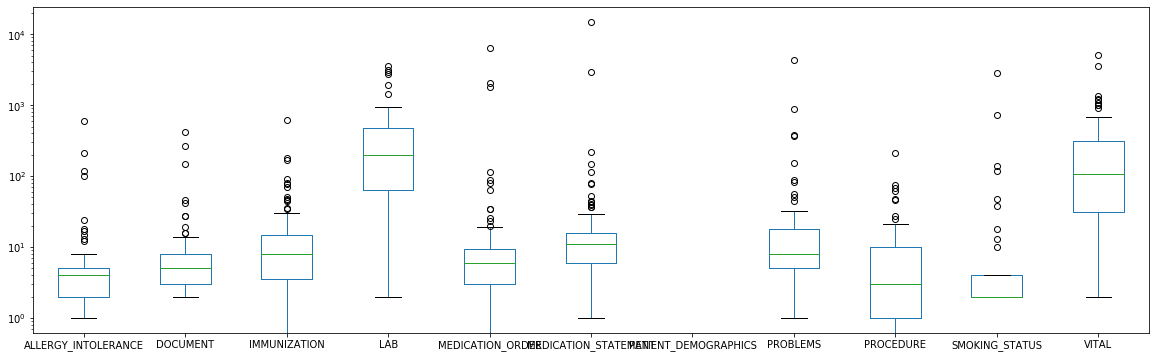

In [39]:
##### S4S Data #####
# Histogram showing counts for each data category, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)

s4s_datatype_totals = {person:{title:len(items) for (title, items) in datatype.items()} for (person, datatype) in s4s_people.items()}
s4s_df = pd.DataFrame(s4s_datatype_totals).transpose()

s4s_df.plot(kind='box', figsize=(20,6), logy=True)

In [11]:
# Count of code *systems* for each data category. E.g., fraction of SNOMED vs LOINC vs Other codes found in Conditions.
coding_paths = {}
for person, documents in s4s_people.items():
    for document, data in documents.items():
        if document not in coding_paths:
            coding_paths[document] = Counter()
        for entry in data:
            fetched = fetch_at_path(entry, path_for_resource(entry))
            if fetched:
                for f in fetched:
                    try:
                        coding_paths[document][f.get('system')] += 1
                    except AttributeError:
                        print('.')
                        raise
            else:
                #this must use a different thing than code.coding
                pass
#                 print(entry['resourceType'])
#                 startNode = Node()
#                 traverse(entry, startNode)
#                 print(startNode)
pp.pprint(coding_paths)

{'ALLERGY_INTOLERANCE': Counter({'http://www.nlm.nih.gov/research/umls/rxnorm': 431,
                                 'http://fdasis.nlm.nih.gov': 202,
                                 'http://hl7.org/fhir/ndfrt': 162,
                                 'http://snomed.info/sct': 134,
                                 'http://hl7.org/fhir/sid/ndc': 25,
                                 None: 25}),
 'DOCUMENT': Counter(),
 'IMMUNIZATION': Counter({'http://hl7.org/fhir/sid/cvx': 1773,
                          'http://hl7.org/fhir/sid/ndc': 272,
                          'http://www.ama-assn.org/go/cpt': 110}),
 'LAB': Counter({'http://hl7.org/fhir/observation-category': 35947, None: 6}),
 'MEDICATION_ORDER': Counter({'http://www.nlm.nih.gov/research/umls/rxnorm': 5031,
                              None: 36,
                              'http://hl7.org/fhir/sid/ndc': 5}),
 'MEDICATION_STATEMENT': Counter({'http://www.nlm.nih.gov/research/umls/rxnorm': 7737,
                                 

In [12]:
extension_paths = {}
for person, documents in s4s_people.items():
    for document, data in documents.items():
        if document not in extension_paths:
            extension_paths[document] = []    
        for entry in data:
            fetched = fetch_at_path(entry, ['extension'])
            if fetched:
                extension_paths[document].extend(fetched)
extension_dfs = {category:pd.DataFrame(data) for (category, data) in extension_paths.items()}
for category, df in extension_dfs.items():
    if 'url' in df.columns:
        print(category, '\n  url')
        pp.pprint(df['url'].value_counts())

MEDICATION_ORDER 
  url
https://open.epic.com/FHIR/Category-Extension                                       529
http://hl7.org/fhir/StructureDefinition/extension-MedicationStatement.category      116
http://hl7.org/fhir/3.0/StructureDefinition/extension-MedicationRequest.category      1
Name: url, dtype: int64
MEDICATION_STATEMENT 
  url
https://fhir-ehr.cerner.com/dstu2/StructureDefinition/medication-statement-category    9451
https://open.epic.com/FHIR/Category-Extension                                           939
http://hl7.org/fhir/StructureDefinition/extension-MedicationStatement.category          212
http://hl7.org/fhir/3.0/StructureDefinition/extension-MedicationStatement.category        2
Name: url, dtype: int64
VITAL 
  url
http://open.epic.com/FHIR/STU3/StructureDefinition/temperature-in-fahrenheit    2151
Name: url, dtype: int64


In [13]:
coding_dfs = {category:pd.DataFrame(data, index=[0]) for (category, data) in coding_paths.items()}
for category, df in coding_dfs.items():
    if 'system' in df.columns:
        print(category, '\n  system')
        pp.pprint(df['system'].value_counts())
    if 'display' in df.columns:
        print('  display')
        pp.pprint(df['display'].value_counts()[:5])

In [14]:
for category, df in coding_dfs.items():
    if 'system' in df.columns:
        print(category, df.columns)
        cat_df = df[['system', 'code', 'display']].groupby(['system'])['code'] \
            .count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            .head(5)
        print(cat_df)

In [15]:
for category, df in coding_dfs.items():
    if 'code' in df.columns:
        print(category, df.columns)
        cat_df = df[['code']].groupby(['code'])['code'] \
            .count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            .head(5)
        print(cat_df)

In [16]:
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?
# Count of valid vs invalid codes for each data category. E.g. how many valid Condition codes, how many invalid, and how many missing?
# Distribution of number of Codings present in CodeableConcepts for each data category. I.e., how often were translation codes supplied for Conditions?

In [17]:
rootNodes = {}
for person, documents in s4s_people.items():
    for document, data in documents.items():
        if document not in rootNodes:
            rootNodes[document] = Node()    
        for entry in data:
            traverse(entry, rootNodes[document])

In [18]:
# Complete "tree" of FHIR paths for each data category. E.g., for Condition, which JSON elements (and sub elements, and so on, recursively) are present?
# Same "tree" of FHIR paths as above, with each node annotated by count. E.g., for Condition.code.coding[0].system, how many times was this path present?
rootNodes

{'PATIENT_DEMOGRAPHICS': Node: {} Children: {},
 'SMOKING_STATUS': Node: {<class 'dict'>: 4191} Children: {
 resourceType: Node: {<class 'str'>: 4191} Children: {}
 issued: Node: {<class 'str'>: 3764} Children: {}
 status: Node: {<class 'str'>: 4046} Children: {}
 id: Node: {<class 'str'>: 4156} Children: {}
 code: Node: {<class 'dict'>: 4046} Children: {
    text: Node: {<class 'str'>: 4020} Children: {}
    coding: Node: {<class 'list'>: 991} Children: {
       0: Node: {<class 'dict'>: 991} Children: {
          system: Node: {<class 'str'>: 991} Children: {}
          code: Node: {<class 'str'>: 991} Children: {}
          display: Node: {<class 'str'>: 596} Children: {}
       }
       1: Node: {<class 'dict'>: 27} Children: {
          system: Node: {<class 'str'>: 27} Children: {}
          code: Node: {<class 'str'>: 27} Children: {}
       }
    }
 }
 subject: Node: {<class 'dict'>: 4046} Children: {
    display: Node: {<class 'str'>: 145} Children: {}
    reference: Node: {<c

In [19]:
# For each status flag, what is the distribution of values? E.g., for Condition.clinicalStatus, how often is the value active | relapse | remission | resolved?

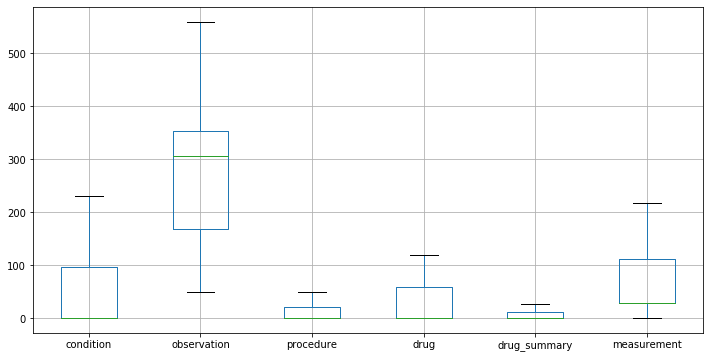

In [20]:
# Histogram showing counts for each OMOP data type, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)
omop_data_types_per_person = {data_type: [len(person[data_type+'.csv']) if data_type+'.csv' in person.keys() else 0 for person in omop_people.values()] for data_type in omop_data_types}
omop_df_types = pd.DataFrame(omop_data_types_per_person, index=omop_people.values())
omop_df_types.boxplot(figsize=(12,6), showfliers=False)

In [21]:
# Count of standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_concept_id.
systems = Counter()
for person, tables in omop_people.items():
    for filename, incidents in tables.items():
        for incident in incidents:
            coding = omop_concept_to_coding(incident, filename)
            if not coding[0][0] or coding[0][0] == 'None':
                systems['None'] += 1
            else:
                systems[coding[0][0]] += 1

systems

Counter({'SNOMED': 14201,
         'RxNorm': 133511,
         'LOINC': 14642,
         'CPT4': 1287,
         'PPI': 7762,
         'None': 11211,
         'ICD9Proc': 97,
         'HCPCS': 23})

In [22]:
# Count of non-standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_source_concept_id

In [23]:
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?


In [24]:
# For each OMOP column, how often was a value present vs absent?
procedure_df = pd.DataFrame(omop_tables['procedure.csv'])
print("Number of rows: ", len(procedure_df))
procedure_columns = set(procedure_df.columns) - {
    'person_id',
    'procedure_date',
    'procedure_datetime',
    'procedure_occurrence_id'
}
for column in procedure_columns:
    print(procedure_df[column].value_counts()[:3])

Number of rows:  2020
            1439
0            438
42739576      53
Name: modifier_concept_id, dtype: int64
0    1582
      438
Name: provider_id, dtype: int64
2108115    154
2414398     85
2414397     69
Name: procedure_concept_id, dtype: int64
1    1582
      438
Name: quantity, dtype: int64
4000000000181312    10
4000000000169699     9
4000000000178509     9
Name: visit_occurrence_id, dtype: int64
2108115    154
2414398     85
2414397     69
Name: procedure_source_concept_id, dtype: int64
cpmc_ceders    1582
nec_phs         438
Name: src_hpo_id, dtype: int64
CPT4        1287
ICD9CM       225
ICD10PCS     202
Name: source_vocabulary, dtype: int64
    2020
Name: qualifier_source_value, dtype: int64
         272
36415    154
99214     85
Name: procedure_source_value, dtype: int64
0           1337
44786630     683
Name: procedure_type_concept_id, dtype: int64
36415    154
99214     85
99213     69
Name: source_code_structured, dtype: int64


In [26]:
print(
    "Number of found procedure_concept_ids in concept tables: ",
    len(concept_df.loc[concept_df.index.isin(procedure_df['procedure_concept_id'])])
)
print(
    "Total number of procedure_concept_ids: ",
    len(procedure_df['procedure_concept_id'].value_counts())
)
missing_procedures = set(procedure_df['procedure_concept_id']) - set(concept_df.index.values) - set(cpt4_df.index.values)
missing_procedures

Number of found procedure_concept_ids in concept tables:  93
Total number of procedure_concept_ids:  340


{'2724216',
 '2724519',
 '2724521',
 '2726351',
 '2738116',
 '2738416',
 '2741398',
 '2741878',
 '2746748',
 '2746758',
 '2746773',
 '2746793',
 '2746803',
 '2747311',
 '2750470',
 '2751060',
 '2751080',
 '2753383',
 '2756532',
 '2772731',
 '2774703',
 '2775232',
 '2778688',
 '2778894',
 '2780613',
 '2780645',
 '2784134',
 '2785970',
 '2785979',
 '2786175',
 '2786185',
 '2786222',
 '2786223',
 '2786229',
 '2786234',
 '2786472',
 '2786479',
 '2786484',
 '2792342',
 '2792981'}

In [27]:
observation_df = pd.DataFrame(omop_tables['observation.csv'])
print("Number of rows: ", len(observation_df))
observation_columns = set(observation_df.columns) - {
    'observation_id',
    'person_id',
    'observation_date',
    'observation_datetime',
}
for column in observation_columns:
    print(observation_df[column].value_counts()[:3])

Number of rows:  21472
bp_diastolic    325
bp_systolic     325
weight          317
Name: observation_source_value, dtype: int64
0         9999
903096    3758
          3007
Name: value_source_concept_id, dtype: int64
0    18465
      3007
Name: qualifier_concept_id, dtype: int64
       20908
2.0      251
0.0       91
Name: value_as_number, dtype: int64
0          12106
1586155      139
1585636      129
Name: observation_source_concept_id, dtype: int64
    21472
Name: qualifier_source_value, dtype: int64
No matching concept                   12106
White_WhiteSpecific                     139
RecreationalDrugUse_WhichDrugsUsed      129
Name: source_code_structured, dtype: int64
     21119
0      353
Name: provider_id, dtype: int64
0           9807
903096      3758
45878245     639
Name: value_as_concept_id, dtype: int64
    21472
Name: unit_source_value, dtype: int64
                    18452
4000000000124506        8
4000000000005711        8
Name: visit_occurrence_id, dtype: int64
0    

In [28]:
print(
    "Number of found observation_concept_ids in concept table: ",
    len(concept_df.loc[concept_df.index.isin(observation_df['observation_concept_id'])])
)
print(
    "Total number of observation_concept_ids: ",
    len(observation_df['observation_concept_id'].value_counts())
)
missing_observations = set(observation_df['observation_concept_id']) - set(concept_df.index.values)

Number of found observation_concept_ids in concept table:  66
Total number of observation_concept_ids:  215


In [29]:
# For each OMOP column, how often was a value present vs absent?
condition_df = pd.DataFrame(omop_tables['condition.csv'])
print("Number of rows: ", len(condition_df))
condition_columns = set(condition_df.columns) - {
    'person_id',
    'condition_start_date',
    'condition_start_datetime',
    'condition_end_date',
    'condition_end_datetime',
    'condition_occurrence_id'
}
for column in condition_columns:
    print(condition_df[column].value_counts()[:3])

Number of rows:  11263
0    6545
     4718
Name: provider_id, dtype: int64
0           4514
44786629    4284
44786627    2465
Name: condition_type_concept_id, dtype: int64
      10898
AD      365
Name: condition_status_source_value, dtype: int64
45556996    610
45552285    404
45600511    396
Name: condition_source_concept_id, dtype: int64
4000000000023113    45
4000000000024074    43
4000000000030830    43
Name: visit_occurrence_id, dtype: int64
    11263
Name: stop_reason, dtype: int64
137809     872
4157332    506
0          495
Name: condition_concept_id, dtype: int64
0           6180
4203942      365
44821787     144
Name: condition_status_concept_id, dtype: int64
cpmc_ceders    6545
nec_phs        4718
Name: src_hpo_id, dtype: int64
ICD10CM    7212
ICD9CM     4051
Name: source_vocabulary, dtype: int64
C50.912    610
C79.51     404
C50.919    396
Name: condition_source_value, dtype: int64
C50.912    610
C79.51     404
C50.919    396
Name: source_code_structured, dtype: int64


In [30]:
print(
    "Number of found condition_concept_ids in concept table: ",
    len(concept_df.loc[concept_df.index.isin(condition_df['condition_concept_id'])])
)
print(
    "Total number of condition_concept_ids: ",
    len(condition_df['condition_concept_id'].value_counts())
)

Number of found condition_concept_ids in concept table:  775
Total number of condition_concept_ids:  775


In [31]:
##### Comparing OMOP to S4S #####
# Draw a distribution of "total # data elements in OMOP vs S4S" for each data category. E;g., each patient would contribute one dot to a Condition Count histogram by taking (# S4S Conditions - # OMOP conditions), which will be a positive number if more S4S conditions, and a negative number of more OMOP conditions.
# TODO (how to specify): show which values appeared in S4S but not OMOP, and vice versa.
# TODO: after early exploration, what else do we want to evaluate?

In [45]:
matched_people = {}
coding_names = {}
for person, tables in omop_people.items():
    matched_people[person] = {
        's4s': {},
        'omop': {},
    }
    #grab omop systems and codes
    for category, rows in tables.items():
        for row in rows:
            if category not in matched_people[person]['omop']:
                matched_people[person]['omop'][category] = Counter()
            coding_key = omop_concept_to_coding(row, category)
            matched_people[person]['omop'][category][coding_key] += 1
    #s4s systems and codes         
    for category, entries in s4s_people[person].items():
        for entry in entries:
            if entry['resourceType'] not in matched_people[person]['s4s']:
                matched_people[person]['s4s'][entry['resourceType']] = Counter()
            codings = fetch_at_path(entry, 'code.coding')
            if codings:
                coding_key = tuple((convert_vocabulary(coding['system']), coding['code']) for coding in codings)
                matched_people[person]['s4s'][entry['resourceType']][coding_key] += 1

In [33]:
# observation_code_names = {
#     'omop': Counter(),
#     's4s': Counter(),
# }
# for person, tables in omop_people.items():
#     for table, row in tables.items():
#         concept = omop_concept_lookup(row['observation_concept_id'])
#         if concept.concept_code == 'No matching concept':
#             pp.pprint(row)
#         observation_code_names['omop'][(concept.concept_code, concept.concept_name)] += 1

# for person, categories in s4s_people.items():
#     for category, entries in categories.items():
#         for entry in entries:
#             if entry['resourceType'] == 'Observation':
#                 codings = fetch_at_path(entry, 'code.coding')
#                 if codings:
#                     for coding in codings:
#                         try:
#                             observation_code_names['s4s'][(coding['code'], coding['display'])] += 1
#                         except KeyError:
#                             pass
                        
# pd.options.display.max_rows = 1000

In [53]:
code_names = {
    'omop': Counter(),
    's4s': Counter(),
}
for person, tables in omop_people.items():
    for table, rows in tables.items():
        for row in rows:
            concept = omop_concept_lookup(row[CODE_COLUMNS[table][0]])
            try:
#                 if concept.concept_code == 'No matching concept':
#                     print(row, concept)
                code_names['omop'][(concept.concept_code, concept.concept_name)] += 1
            except AttributeError as e:
                pass
#                 print(e, concept, row)

for person, categories in s4s_people.items():
    for category, entries in categories.items():
        for entry in entries:
            codings = fetch_at_path(entry, path_for_resource(entry))
            if codings:
                for coding in codings:
                    try:
                        code_names['s4s'][(coding['code'], coding['display'])] += 1
                    except KeyError:
                        pass
                        
pd.options.display.max_rows = 1000

In [54]:
pd.DataFrame(code_names['omop'].most_common())

,0,1
0,"(No matching concept, No matching concept)",11009
1,"(229819007, Tobacco use and exposure)",2654
2,"(1049221, Acetaminophen 325 MG / Oxycodone Hyd...",1574
3,"(197806, Ibuprofen 600 MG Oral Tablet)",1481
4,"(861007, Metformin hydrochloride 500 MG Oral T...",947
5,"(1115005, Docusate Sodium 100 MG Oral Capsule)",890
6,"(93796005, Primary malignant neoplasm of femal...",872
7,"(313782, Acetaminophen 325 MG Oral Tablet)",852
8,"(310385, Fluoxetine 20 MG Oral Capsule)",835
9,"(314076, Lisinopril 10 MG Oral Tablet)",747


In [55]:
pd.DataFrame(code_names['s4s'].most_common())

,0,1
0,"(laboratory, Laboratory)",35540
1,"(vital-signs, Vital Signs)",28268
2,"(diagnosis, Diagnosis)",5447
3,"(social-history, Social History)",3765
4,"(problem, Problem)",1964
5,"(29308-4, Diagnosis)",1108
6,"(439401001, Diagnosis)",1108
7,"(308416, Aspir 81 oral delayed release tablet)",620
8,"(3498, Diphenhydramine)",476
9,"(8640, Prednisone)",460


In [66]:
unique_codable_concepts = {}
from itertools import chain
for person, datasets in matched_people.items():
    #gather all omop codes to compare against
    omop_codes = set()
    for table, concepts in datasets['omop'].items():
        omop_codable_concepts = concepts.keys()
        omop_codes.update(set([v for v in chain(*omop_codable_concepts)]))
    unique_codable_concepts[person] = {category:{} for category in datasets['s4s'].keys()}
    for category, concepts in datasets['s4s'].items():
        s4s_codable_concepts = concepts.keys()
        s4s_codes = set([v for v in chain(*s4s_codable_concepts)])
        s4s_split = split_codable_concepts(s4s_codable_concepts, omop_codes)
        unique_codable_concepts[person][category] = {
            's4s_total': sum(concepts.values()),
            's4s_unique': len(concepts),
            'S4S_CC_matched': len(s4s_split['matched']),
            'S4S_CC_unmatched': len(s4s_split['unmatched']),
        }
codable_concepts_df = pd.DataFrame(unique_codable_concepts).transpose()
codable_concepts_df.reset_index(inplace=True)
codable_concepts_df.drop(columns='index', inplace=True)
pd.options.display.max_rows = 100
codable_concepts_df

,AllergyIntolerance,Condition,DocumentReference,Immunization,MedicationOrder,MedicationStatement,Observation,OperationOutcome,Procedure
0,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 4, 's4s_unique': 4, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...",NaN,NaN,"{'s4s_total': 49, 's4s_unique': 12, 'S4S_CC_ma...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 12, 's4s_unique': 4, 'S4S_CC_mat..."
1,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 3, 's4s_unique': 3, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...",NaN,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 60, 's4s_unique': 50, 'S4S_CC_ma...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 1, 's4s_unique': 1, 'S4S_CC_matc..."
2,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...",NaN,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...",NaN,NaN,"{'s4s_total': 267, 's4s_unique': 66, 'S4S_CC_m...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 2, 's4s_unique': 1, 'S4S_CC_matc..."
3,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 8, 's4s_unique': 8, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 154, 's4s_unique': 64, 'S4S_CC_m...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...",NaN
4,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 6, 's4s_unique': 3, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 74, 's4s_unique': 17, 'S4S_CC_ma...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 8, 's4s_unique': 3, 'S4S_CC_matc..."
5,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 4, 's4s_unique': 3, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...",NaN,NaN,"{'s4s_total': 928, 's4s_unique': 61, 'S4S_CC_m...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 14, 's4s_unique': 4, 'S4S_CC_mat..."
6,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 30, 's4s_unique': 15, 'S4S_CC_ma...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 2138, 's4s_unique': 139, 'S4S_CC...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 4, 's4s_unique': 1, 'S4S_CC_matc..."
7,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 42, 's4s_unique': 42, 'S4S_CC_ma...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 1062, 's4s_unique': 134, 'S4S_CC...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 54, 's4s_unique': 9, 'S4S_CC_mat..."
8,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 8, 's4s_unique': 8, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 621, 's4s_unique': 73, 'S4S_CC_m...","{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...",NaN
9,"{'s4s_total': 0, 's4s_unique': 0, 'S4S_CC_matc...","{'s4s_total': 2, 's4s_unique': 1, 'S4S_CC_matc...","{'s4s_t

In [38]:
missing_concept_codes

{'',
 '1010033.0',
 '1010688.0',
 '1010739.0',
 '1010751.0',
 '1012377.0',
 '1014314.0',
 '1014678.0',
 '1020477.0',
 '1046815.0',
 '104894.0',
 '1049160.0',
 '1049167.0',
 '1049214.0',
 '1049221.0',
 '1049633.0',
 '1049909.0',
 '106258.0',
 '106302.0',
 '1085644.0',
 '1087026.0',
 '1094107.0',
 '1099678.0',
 '1099870.0',
 '1115005.0',
 '1116294.0',
 '1116927.0',
 '1119400.0',
 '1190572.0',
 '1191222.0',
 '1234579.0',
 '1234995.0',
 '1243769.0',
 '1244214.0',
 '1245468.0',
 '1247759.0',
 '1291082.0',
 '1298066.0',
 '1359022.0',
 '1359894.0',
 '1361615.0',
 '1367410.0',
 '142004.0',
 '1490065.0',
 '150985.0',
 '1594589.0',
 '1601380.0',
 '1601388.0',
 '1648755.0',
 '1649988.0',
 '1659930.0',
 '1665050.0',
 '1665107.0',
 '1665692.0',
 '197303.0',
 '197304.0',
 '197310.0',
 '197311.0',
 '197313.0',
 '197319.0',
 '197320.0',
 '197361.0',
 '197379.0',
 '197380.0',
 '197381.0',
 '197391.0',
 '197397.0',
 '197444.0',
 '197446.0',
 '197511.0',
 '197517.0',
 '197518.0',
 '197541.0',
 '197557.0'